## Transfer Learning with MobileNetV2
A pre-trained model is a model that's been trained on a large dataset and saved, which allows us to use it to customize our model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 minllion images and 1000 classes.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
MY_SEED = 42

## Load our images

In [4]:
IMAGE_SIZE = (160, 160)
directory = './dataset'
train_dataset = tf.keras.utils.image_dataset_from_directory(directory, 
                                            batch_size=32, 
                                            image_size=IMAGE_SIZE, 
                                            shuffle=True,
                                            seed=MY_SEED, 
                                            subset='training', 
                                            validation_split=0.2)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory, 
                                            batch_size=32, 
                                            image_size=IMAGE_SIZE, 
                                            subset='validation', 
                                            seed=MY_SEED, 
                                            validation_split=0.2, 
                                            shuffle=True)

Found 327 files belonging to 2 classes.


Using 262 files for training.


2023-11-27 23:12:59.761710: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-11-27 23:12:59.761735: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-27 23:12:59.761743: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-27 23:12:59.761925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 23:12:59.761949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 327 files belonging to 2 classes.
Using 65 files for validation.


## Explore the data
Each sub-directory representes a class.

In [5]:
class_names = train_dataset.class_names
print(class_names)

['alpaca', 'not alpaca']


In [6]:
print('Number of training batches:', len(train_dataset))
print('Number of training batches:', len(validation_dataset))

for data, labels in train_dataset.take(1): 
    print('Shape of the first batch', data.shape)
    print('labels', labels)


Number of training batches: 9
Number of training batches: 3
Shape of the first batch (32, 160, 160, 3)
labels tf.Tensor([0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0], shape=(32,), dtype=int32)


There are 32 images in each batch, each image has shape (160, 160, 3).

The labels contains 32 true labels for images in a batch

Now let's take a look at some of the images from the training set: 

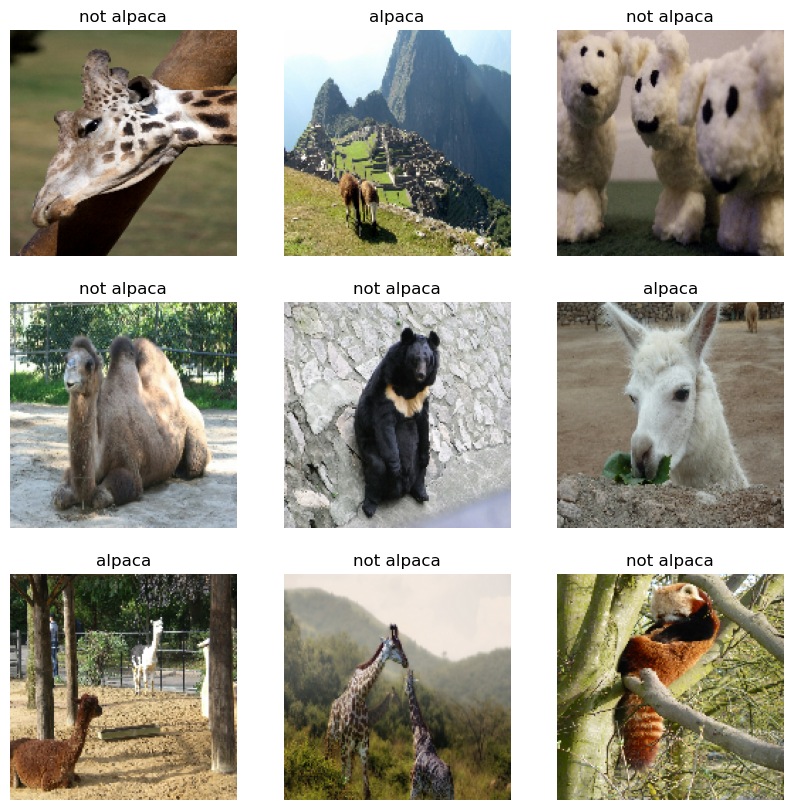

In [7]:
plt.figure(figsize=(10, 10))
for data, labels in train_dataset.take(1): 
    # Plot 9 images
    for i in range(9): 
        ax = plt.subplot(3, 3, i+1)
        ax.set_title(class_names[labels[i]])
        ax.imshow(tf.cast(data[i], tf.int16) )
        ax.axis('off')
        

## Preprocess and Augment Training Data
Using `.prefetch()` prevents memory bottleneck that can occur when reading from the disk. It sets aside some data and keeps it ready for when it's needed. Because the iteration is streaming, the data doesn't need to fit into memory

You can set the number of elements to prefetch manually, or you can use `tf.data.AUTOTUNE` to choose the parameters automatically. `AUTOTUNE` prompts `tf.data` to tune the value dynamically at runtime, by tracking the time spent in each operation and feeding those times into optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmenter
To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kind of data augmentations, with built-in, customizable preprocessing layers.

In [9]:
def data_augmenter(): 
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    return data_augmentation

2023-11-27 23:13:02.104316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:02.607235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:02.635831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:02.662524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:02.694079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:02.731933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

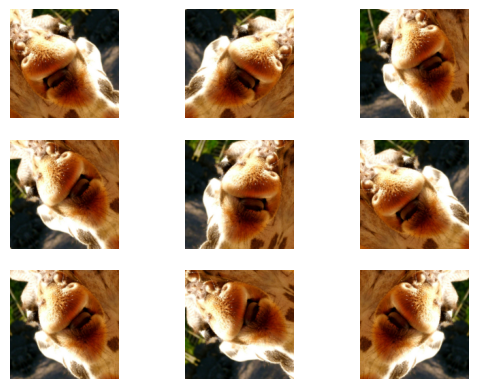

In [10]:
data_augmentation = data_augmenter()
for image, labels in train_dataset.take(1): 
    first_image = image[0]
    for i in range(9): 
        # Third paramenter is index which starts from 1
        ax = plt.subplot(3, 3, i + 1)
        
        # Expand input from (160, 160, 3) to (1, 160, 160, 3)
        augmented_image = data_augmentation(tf.expand_dims(first_image, axis=0))
        
        ax.imshow(augmented_image[0]/255)
        ax.axis('off')

Next, you'll apply your first tool from the `MobileNet` application in Tensorflow, to normalize our input. Since we're using a pre-trained model that was trained on the normalization values [-1, 1], it's best practice to reuse that standard with `tf.keras.applications.mobilenet_v2.preprocess_input`

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Using MobileNetV2 for Transfer Learning
MobileNetV2 was trained on ImageNet dataset and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics: 
- Depthwise separable convolutions
- Thin input and output bottlenecks between layers
- Shortcut connections between bottleneck layers

## Inside a MobileNetV2 Convolutional Building Block
MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 
  1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.
  2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is pointwise convolution

Let's try to train the the base model using `all the layers` from the pre-trained model.

Similarly to how we reused the pre-trained normalization values MobileNetV2 was trained on, we'll also load the pre-trained weights from `ImageNet` by specifying `weights='imagenet'`

In [12]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                               include_top=True, 
                                               weights='imagenet')

Run the following code to see the summary of the model's layers, the shape of their outputs and the total number of paramenters, trainable and non-trainable.

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

Note the last 2 layers. They are also called the top layers, and they are responsible for the classification in the model.

In [14]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers-2].name)
print(base_model.layers[nb_layers-1].name)

global_average_pooling2d
predictions


Try to predict images from the pre-trained model without any our touch.

In [15]:
image_batch, label_batch = next(iter(train_dataset)) 
feature_batch = base_model(image_batch)
print(feature_batch)

tf.Tensor(
[[9.8283243e-05 1.9144930e-03 4.4584882e-05 ... 2.6842492e-04
  3.6077027e-03 9.5092277e-05]
 [1.7731049e-04 1.2162059e-03 7.9034922e-05 ... 2.2906293e-04
  2.2325250e-03 1.1210472e-04]
 [2.8033357e-04 4.3590739e-04 1.4247216e-04 ... 3.0232095e-05
  1.7305241e-04 3.0048593e-04]
 ...
 [6.3017185e-05 2.4286823e-04 3.4091031e-04 ... 1.2469238e-04
  4.2749907e-05 7.1635375e-05]
 [1.8517456e-04 7.9307880e-04 5.8819736e-05 ... 2.6901120e-05
  5.7937152e-05 1.7872077e-04]
 [7.2829243e-05 1.5999294e-04 2.2470658e-05 ... 3.3840879e-05
  5.2488066e-04 4.7796853e-05]], shape=(32, 1000), dtype=float32)


Now decode the predictions made by the model. Ealier, when we printed the shape of the model, it would have returned (32, 1000). The number 32 refer to the batch size and 1000 refers to 1000 classes the model was pre-trained on. The predictions returned by the base model follow this format: 

First the class number, then a human-readable label, and last the probability of the image belonging to that class. We'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [16]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)
decoded_pred = tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)
decoded_pred

[[('n02454379', 'armadillo', 0.89280725),
  ('n02172182', 'dung_beetle', 0.024269188)],
 [('n02437312', 'Arabian_camel', 0.29541275),
  ('n02134084', 'ice_bear', 0.043125104)],
 [('n01616318', 'vulture', 0.075223185), ('n02130308', 'cheetah', 0.06773613)],
 [('n02437616', 'llama', 0.98138875),
  ('n02437312', 'Arabian_camel', 0.00090886955)],
 [('n02483362', 'gibbon', 0.16563366),
  ('n02509815', 'lesser_panda', 0.100415535)],
 [('n02133161', 'American_black_bear', 0.8799118),
  ('n02132136', 'brown_bear', 0.019821703)],
 [('n01518878', 'ostrich', 0.957881), ('n02018795', 'bustard', 0.0029069672)],
 [('n02437616', 'llama', 0.7814703),
  ('n02098286', 'West_Highland_white_terrier', 0.043964114)],
 [('n02410509', 'bison', 0.45431334), ('n02132136', 'brown_bear', 0.4516927)],
 [('n02133161', 'American_black_bear', 0.6910855),
  ('n02132136', 'brown_bear', 0.08774405)],
 [('n01518878', 'ostrich', 0.87967277),
  ('n02018795', 'bustard', 0.0077298884)],
 [('n02437616', 'llama', 0.4719324), (

## Layer Freezing with Functional API
In this next sections, we'll see how we can use the pre-trained model and modify the classifier task so that it's able to recognize alpacas. We can achieve this in three steps: 
1. Delete the top layer (the classification layer)
  - Set `include_top` in `base_model` as False
2. Add a new classifier layer
  - Train only one layer by freezing the rest of the network
  - A single neuron is enough to solve a binary classification problem
3. Freeze the base model and train the newly-created classifier layer
  - Set `base_model.trainable=False` to avoid changing the weights and train **only** the new layer
  - Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [17]:
def alpaca_model(image_size=IMAGE_SIZE, data_augmentation=data_augmenter()): 
    input_shape = image_size + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, 
                                                   include_top=False, 
                                                   weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)
    return model
    

Create new model by using data_augmentation function defined earlier.

In [18]:
model2 = alpaca_model(IMAGE_SIZE, data_augmentation)

In [19]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [20]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate), 
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
               metrics=['accuracy'])

In [21]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs
                     )

Epoch 1/5


2023-11-27 23:13:09.725473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-27 23:13:10.107169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/9 [=========>....................] - ETA: 0s - loss: 0.8144 - accuracy: 0.4583

2023-11-27 23:13:12.108572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:12.160728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:12.244543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:12.302524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


8/9 [=========================>....] - ETA: 0s - loss: 0.7741 - accuracy: 0.5000

2023-11-27 23:13:12.426950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:12.479491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:12.527138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:12.593095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - ETA: 0s - loss: 0.7663 - accuracy: 0.5115

2023-11-27 23:13:13.586546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 8s 459ms/step - loss: 0.7663 - accuracy: 0.5115 - val_loss: 0.6532 - val_accuracy: 0.4923
Epoch 2/5


2023-11-27 23:13:15.785643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/9 [===============>..............] - ETA: 0s - loss: 0.5887 - accuracy: 0.6687

2023-11-27 23:13:16.180072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:16.230759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:16.291823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:16.336839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:16.376955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.6565

2023-11-27 23:13:16.418418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:16.456411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:16.491760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 1s 66ms/step - loss: 0.5859 - accuracy: 0.6565 - val_loss: 0.5411 - val_accuracy: 0.5846
Epoch 3/5


2023-11-27 23:13:16.707196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/9 [===============>..............] - ETA: 0s - loss: 0.4829 - accuracy: 0.6812

2023-11-27 23:13:17.093819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:17.130949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:17.166825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:17.201445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:17.236496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:17.275302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

8/9 [=========================>....] - ETA: 0s - loss: 0.4585 - accuracy: 0.7070

2023-11-27 23:13:17.316755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:17.370289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 1s 60ms/step - loss: 0.4541 - accuracy: 0.7137 - val_loss: 0.4619 - val_accuracy: 0.6308
Epoch 4/5


2023-11-27 23:13:17.575540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/9 [===============>..............] - ETA: 0s - loss: 0.4559 - accuracy: 0.7375

2023-11-27 23:13:17.910773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:17.946132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:17.982996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.022775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.064787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.099932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

9/9 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.7710

2023-11-27 23:13:18.137321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.178099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 1s 58ms/step - loss: 0.4095 - accuracy: 0.7710 - val_loss: 0.3868 - val_accuracy: 0.7077
Epoch 5/5


2023-11-27 23:13:18.377100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/9 [===============>..............] - ETA: 0s - loss: 0.4178 - accuracy: 0.8250

2023-11-27 23:13:18.715261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.752789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.792250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.841622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.878450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.915327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

9/9 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8053

2023-11-27 23:13:18.953577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:18.991450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 1s 57ms/step - loss: 0.3950 - accuracy: 0.8053 - val_loss: 0.3534 - val_accuracy: 0.7385


In [22]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [23]:
print(acc)

[0.5114504098892212, 0.6564885377883911, 0.7137404680252075, 0.7709923386573792, 0.805343508720398]


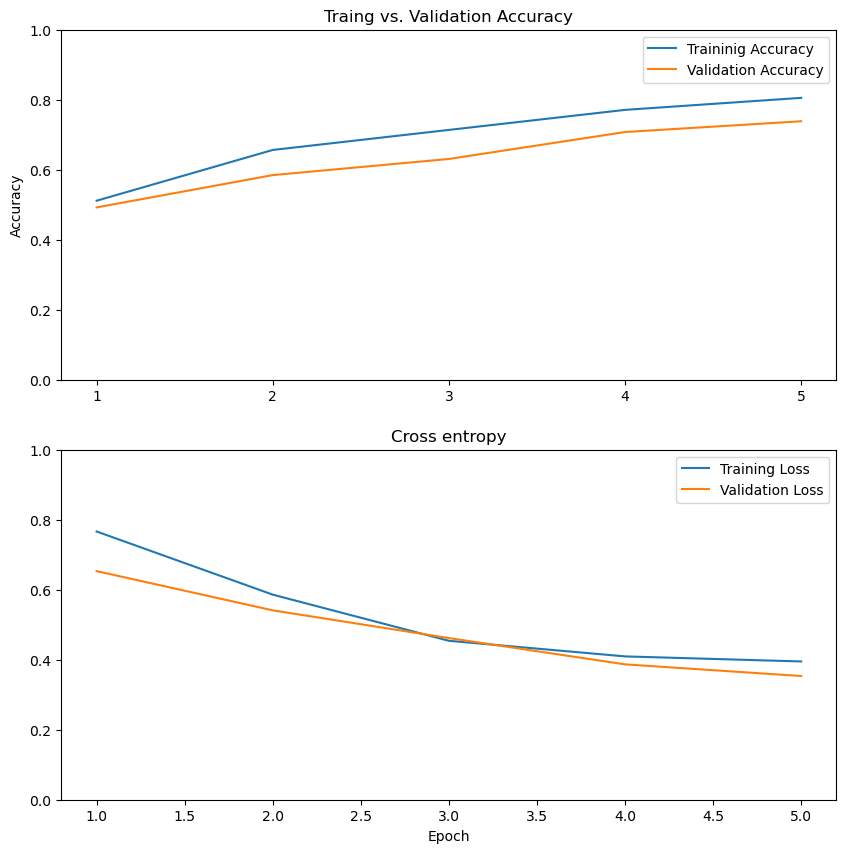

In [24]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)

ax.plot(np.arange(1, len(acc) +1), acc, label='Traininig Accuracy')
ax.plot(np.arange(1, len(acc) +1), val_acc, label='Validation Accuracy')
ax.legend()
ax.set_ylim([0, 1])
ax.set_ylabel('Accuracy')
ax.set_title('Traing vs. Validation Accuracy')
ax.set_xticks(np.arange(1, len(acc) +1))

ax = plt.subplot(2, 1, 2)
ax.plot(np.arange(1, len(acc) +1), loss, label='Training Loss')
ax.plot(np.arange(1, len(acc) +1), val_loss, label='Validation Loss')
ax.set_ylim([0, 1.0])
ax.set_title('Cross entropy')
ax.legend()
ax.set_xlabel('Epoch')
plt.show()

The results are ok, but could be better. Next, try some `fine-tunning`

In [25]:
model2.layers

## Fine-tunning the Model
We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When we use a smaller learning rate, we take a smaller step to adapt it a little more closely to the new data. In transfer learning, the way we achive this is by unfreezing the layers at the end of the network, and then re-training our model on the final layers with a very low learning rate. Adapting our leanring rate to go over these layers in smaller steps can yiel more find details - and higher accuracy.

To achive this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozon.

In [26]:
base_model = model2.layers[4]
base_model.trainable = True
print('Number of layers in the base model: ', len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 20
# Freeze all the layers before `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]: 
    layer.trainable = False
    
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1*base_learning_rate)
metrics = ['accuracy']
model2.compile(optimizer=optimizer, 
               loss=loss_function, 
               metrics=metrics)

Number of layers in the base model:  154


In [27]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [28]:

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs
history_tune = model2.fit(train_dataset, epochs=total_epochs,
                          initial_epoch=history.epoch[-1], 
                        validation_data=validation_dataset)

Epoch 5/10


2023-11-27 23:13:21.643772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-27 23:13:22.280833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/9 [=====>........................] - ETA: 0s - loss: 0.5948 - accuracy: 0.7188 

2023-11-27 23:13:25.320070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:25.427298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/9 [===============>..............] - ETA: 0s - loss: 0.5322 - accuracy: 0.7625

2023-11-27 23:13:25.535279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:25.627049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:25.706013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


8/9 [=========================>....] - ETA: 0s - loss: 0.5061 - accuracy: 0.7383

2023-11-27 23:13:25.787801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:25.872587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:25.960882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - ETA: 0s - loss: 0.5176 - accuracy: 0.7366

2023-11-27 23:13:27.898419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 10s 487ms/step - loss: 0.5176 - accuracy: 0.7366 - val_loss: 0.3580 - val_accuracy: 0.7385
Epoch 6/10


2023-11-27 23:13:29.216409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/9 [=========>....................] - ETA: 0s - loss: 0.3791 - accuracy: 0.8438

2023-11-27 23:13:29.625127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:29.714036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:29.823249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/9 [===============>..............] - ETA: 0s - loss: 0.3626 - accuracy: 0.8875

2023-11-27 23:13:29.973618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:30.105777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/9 [===================>..........] - ETA: 0s - loss: 0.3562 - accuracy: 0.8906

2023-11-27 23:13:30.184782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8626

2023-11-27 23:13:30.393763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:30.487248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 2s 145ms/step - loss: 0.3529 - accuracy: 0.8626 - val_loss: 0.4173 - val_accuracy: 0.6308
Epoch 7/10


2023-11-27 23:13:30.783492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/9 [=========>....................] - ETA: 0s - loss: 0.2748 - accuracy: 0.8438

2023-11-27 23:13:31.180973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:31.256842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:31.331822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/9 [===================>..........] - ETA: 0s - loss: 0.3008 - accuracy: 0.8490

2023-11-27 23:13:31.415975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:31.494473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:31.571158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.8550

2023-11-27 23:13:31.649001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:31.728974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 1s 101ms/step - loss: 0.2815 - accuracy: 0.8550 - val_loss: 0.2252 - val_accuracy: 0.8769
Epoch 8/10


2023-11-27 23:13:31.988661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/9 [=========>....................] - ETA: 0s - loss: 0.1527 - accuracy: 0.9375

2023-11-27 23:13:32.349935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:32.463595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:32.546264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/9 [===================>..........] - ETA: 0s - loss: 0.1514 - accuracy: 0.9427

2023-11-27 23:13:32.624172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:32.697931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:32.773123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


8/9 [=========================>....] - ETA: 0s - loss: 0.1844 - accuracy: 0.9102

2023-11-27 23:13:32.846316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:32.922783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 1s 110ms/step - loss: 0.1813 - accuracy: 0.9122 - val_loss: 0.1770 - val_accuracy: 0.9385
Epoch 9/10


2023-11-27 23:13:33.235922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/9 [=========>....................] - ETA: 0s - loss: 0.1804 - accuracy: 0.9479

2023-11-27 23:13:33.669329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:33.747151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:33.831117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/9 [===================>..........] - ETA: 0s - loss: 0.1554 - accuracy: 0.9479

2023-11-27 23:13:33.910701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:33.989010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:34.067298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


8/9 [=========================>....] - ETA: 0s - loss: 0.1532 - accuracy: 0.9453

2023-11-27 23:13:34.143667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:34.220974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 1s 115ms/step - loss: 0.1509 - accuracy: 0.9466 - val_loss: 0.1354 - val_accuracy: 0.9692
Epoch 10/10


2023-11-27 23:13:34.588866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/9 [=========>....................] - ETA: 0s - loss: 0.1069 - accuracy: 0.9479

2023-11-27 23:13:34.943084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:35.020170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:35.097821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/9 [===================>..........] - ETA: 0s - loss: 0.1230 - accuracy: 0.9479

2023-11-27 23:13:35.171606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:35.244788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:35.316268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9427

2023-11-27 23:13:35.397534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-27 23:13:35.474476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


9/9 [==============================] - 1s 102ms/step - loss: 0.1268 - accuracy: 0.9427 - val_loss: 0.1095 - val_accuracy: 0.9538


In [29]:
history.epoch

[0, 1, 2, 3, 4]

In [30]:
acc += history_tune.history['accuracy']
val_acc += history_tune.history['val_accuracy']

loss += history_tune.history['loss']
val_loss += history_tune.history['val_loss']

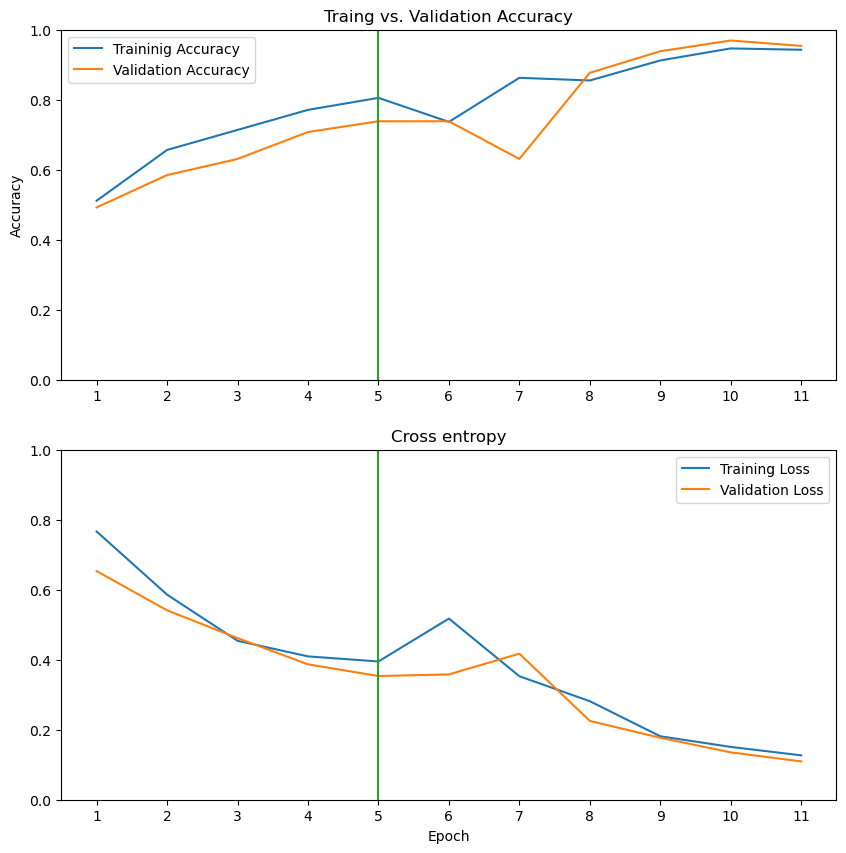

In [31]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Ax 1
ax.plot(np.arange(1, len(acc) +1), acc, label='Traininig Accuracy')
ax.plot(np.arange(1, len(acc) +1), val_acc, label='Validation Accuracy')
ax.legend()
ax.set_ylim([0, 1])
ax.plot([history.epoch[-1] + 1, history.epoch[-1] + 1], (ax.get_ylim()))
ax.set_ylabel('Accuracy')
ax.set_title('Traing vs. Validation Accuracy')
ax.set_xticks(np.arange(1, len(acc) +1))

# Ax 2
ax = plt.subplot(2, 1, 2)
ax.plot(np.arange(1, len(acc) +1), loss, label='Training Loss')
ax.plot(np.arange(1, len(acc) +1), val_loss, label='Validation Loss')
ax.set_ylim([0, 1.0])
ax.plot([history.epoch[-1] + 1, history.epoch[-1] + 1], (ax.get_ylim()))
ax.set_title('Cross entropy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(1, len(acc) +1))
plt.show()